In [2]:
import torch
from gpt import GPT, generate_text_simple

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPT(GPT_CONFIG_124M)
model.eval();


In [3]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})
    encoded_tesor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tesor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())


tokenizer = tiktoken.get_encoding('gpt2')

In [4]:
token_ids_to_text(text_to_token_ids("Hi Aniket", tokenizer), tokenizer)

'Hi Aniket'

In [5]:

start_context = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size= GPT_CONFIG_124M['context_length']
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you rentingetic wasnم refres RexMeCHicular stren


In [6]:

inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]


In [7]:
with torch.no_grad():
    logits = model(inputs)

In [8]:
probas = torch.softmax(logits, dim=-1)
print(probas.shape)

torch.Size([2, 3, 50257])


In [9]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print(token_ids)

tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [10]:
text_idx = 0
target_probas_1 = probas[text_idx, [0,1,2], targets[text_idx]]
print(target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0,1,2], targets[text_idx]]
print(target_probas_2)

tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [11]:
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


In [12]:
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


In [13]:
neg_avg_log_probas = avg_log_probas* -1
neg_avg_log_probas

tensor(10.7940)

In [14]:
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()

print(logits_flat.shape)
print(targets_flat.shape)

torch.Size([6, 50257])
torch.Size([6])


In [15]:
loss = torch.nn.functional.cross_entropy(logits_flat,targets_flat)
print(loss)

tensor(10.7940)


In [16]:
perplexity = torch.exp(loss)
perplexity

tensor(48725.8203)

In [17]:
file_path = 'the-verdict.txt'

with open(file_path,'r', encoding='utf-8') as f:
    raw_text = f.read()

In [18]:
total_characters = len(raw_text)
total_tokens = len(tokenizer.encode(raw_text))

print(total_characters)
print(total_tokens)

20479
5145


## data preparation

In [19]:
from gpt import create_dataloader

train_ratio = 0.90
train_data = raw_text[:int(len(raw_text)*train_ratio)]
val_data = raw_text[int(train_ratio*len(raw_text)):]


torch.manual_seed(123)

train_loader = create_dataloader(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M['context_length'],
    stride=GPT_CONFIG_124M['context_length'],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [20]:
print('train')
for x,y in train_loader:
    print(x.shape, y.shape)

print("val")
for x,y in val_loader:
    print(x.shape, y.shape)

train
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
val
torch.Size([2, 256]) torch.Size([2, 256])


In [21]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
    return loss


def calc_loss_loader(data_loader, model, device, num_batches = None):
    total_loss = .0
    if len(data_loader) == 0:
        return float('nan')
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i< num_batches:
            loss = calc_loss_batch(input_batch, target_batch,model, device)
            total_loss += loss.item()
        else:
            break

    return total_loss/ num_batches

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [23]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print('train loss', train_loss)
print('val loss', val_loss)

train loss 10.98758347829183
val loss 10.98110580444336


## train the model

In [25]:
def train_model_simple(model,train_loader,val_loader,optimizer, device, num_epochs, eval_freq,eval_iter, start_context, tokenizer):

    train_losses, val_losses, track_tokens_seen = [],[],[]
    tokens_seen, global_step = 0,-1

    for epoch in range(num_epochs):

        model.train()

        for input_batch, target_batch in train_loader:

            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch,model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step% eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Steps {global_step:06d}): Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        generate_and_print_sample(model, tokenizer,device, start_context)

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader,device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter )

    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):

    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx = encoded, max_new_tokens= 50, context_size=context_size
        )
    
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()



    

In [27]:
torch.manual_seed(123)

model = GPT(GPT_CONFIG_124M)
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(model, train_loader, val_loader,optimizer,device, num_epochs,eval_freq=5,eval_iter=5, start_context="Every efforts moves you", tokenizer=tokenizer)

Ep 1 (Steps 000000): Train loss 9.781, Val loss 9.930
Ep 1 (Steps 000005): Train loss 8.116, Val loss 8.343
Every efforts moves you,,,,,,,,,,,,.                                     
Ep 2 (Steps 000010): Train loss 6.669, Val loss 7.055
Ep 2 (Steps 000015): Train loss 5.963, Val loss 6.618
Every efforts moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Steps 000020): Train loss 6.617, Val loss 7.067
Ep 3 (Steps 000025): Train loss 5.236, Val loss 6.362
Every efforts moves you, and I had been the picture to the to the picture.               "I"IHe the picture, and I had been, and I had been, and I had the
Ep 4 (Steps 000030): Train loss 4.917, Val loss 6.341
Ep 4 (Steps 000035): Train loss 4.416, Val loss 6.295
Every efforts moves you, and, and, and, and, and, and I was.                                   
Ep 5 (Steps 000040): Train loss 3.966, Val loss 6.152
Every efforts moves you know the           

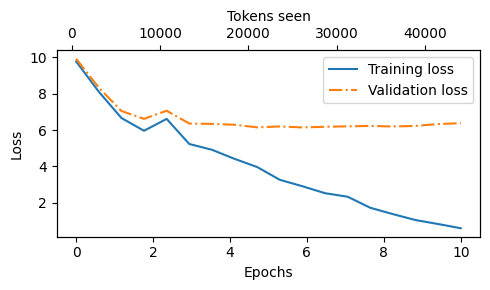

In [28]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [29]:

torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    }, 
    "model_and_optimizer.pth"
)

In [30]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPT(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train();

In [34]:

model.to("cpu")
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




In [39]:
def generate(model, idx, max_new_tokens, context_size, temperature = 0.0, top_k = None, eos_id =None):
    for _ in range(max_new_tokens):

        idx_cond = idx[:, -context_size:]
        model.eval()
        with torch.no_grad():
            logits = model(idx_cond)

        logits = logits[:,-1,:]

        if top_k is not None:
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:,-1]
            logits = torch.where(
                logits<min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )

        if temperature>0.0:
            logits = logits/temperature
            probs = torch.softmax(logits, dim = -1)

            idx_next = torch.multinomial(probs, num_samples=1)

        else:
            idx_next = torch.argmax(logits, dim =-1, keepdim=True)

        idx = torch.cat((idx, idx_next), dim = 1)

    return idx

In [40]:

torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you not to work on surprise, a picture to face watching me by his knees
